In [0]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/home/z/Documents/NLP/Jupyter/venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
#alt.renderers.enable('notebook')

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")



In [0]:
import pandas as pd
df = pd.read_csv('last.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,id,text,EF_Label,Sentence_with_EF
0,2,2,13702,Admission Date: [**2119-5-4**] D...,0.0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6..."
1,11,11,1136,Admission Date: [**2192-4-19**] ...,1.0,['EF 40%)']
2,17,17,79900,Admission Date: [**2194-7-18**] ...,1.0,"['EF 35%)', 'EF 35%), AICD p/w SOB and']"
3,21,21,9805,Admission Date: [**2131-7-5**] D...,1.0,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']"
4,36,36,30812,Admission Date: [**2143-11-22**] ...,0.0,['EF 70%) The right ventricular free wall is']


In [0]:
from io import StringIO
col = ['EF_Label', 'Sentence_with_EF']
df = df[col]
df = df[pd.notnull(df['Sentence_with_EF'])]
df.columns = ['EF_Label', 'Sentence_with_EF']
df['labels'] = df['EF_Label'].factorize()[0]
df['text'] = df['Sentence_with_EF']
df.head(10)

,EF_Label,Sentence_with_EF,labels,text
0,0.0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...",0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6..."
1,1.0,['EF 40%)'],1,['EF 40%)']
2,1.0,"['EF 35%)', 'EF 35%), AICD p/w SOB and']",1,"['EF 35%)', 'EF 35%), AICD p/w SOB and']"
3,1.0,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']",1,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']"
4,0.0,['EF 70%) The right ventricular free wall is'],0,['EF 70%) The right ventricular free wall is']
5,0.0,['EF 60%'],0,['EF 60%']
6,1.0,"['EF 30%, moderate MR, and moderate']",1,"['EF 30%, moderate MR, and moderate']"
7,1.0,"['EF 20%,', 'EF 20%, PVD s/p R BKA with']",1,"['EF 20%,', 'EF 20%, PVD s/p R BKA with']"
8,1.0,"['EF 30%). No masses or', 'EF 65%) presents wi...",1,"['EF 30%). No masses or', 'EF 65%) presents wi..."
9,1.0,['EF 50%). Right ventricular chamber size and ...,1,['EF 50%). Right ventricular chamber size and ...


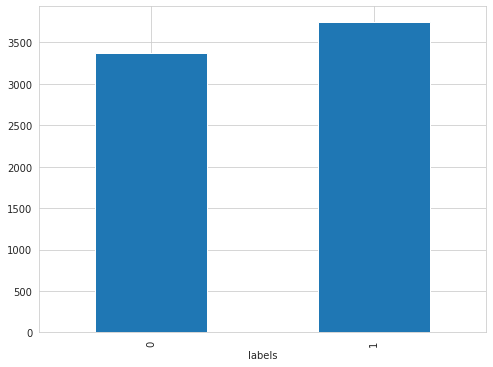

In [0]:
# here to visulize the class distrubation 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6)) # size of figure 
df.groupby('labels').labels.count().plot.bar(ylim=0)
plt.show()

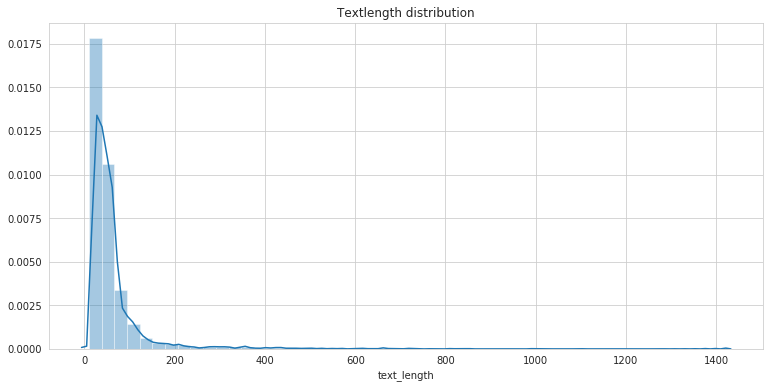

In [0]:
#Text length by Class
df['text_length'] = df['text'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(df['text_length']).set_title('Textlength distribution');

In [0]:
df['text_length'].describe()


count    7115.000000
mean       55.660436
std        78.878183
min        10.000000
25%        20.000000
50%        38.000000
75%        61.000000
max      1416.000000
Name: text_length, dtype: float64

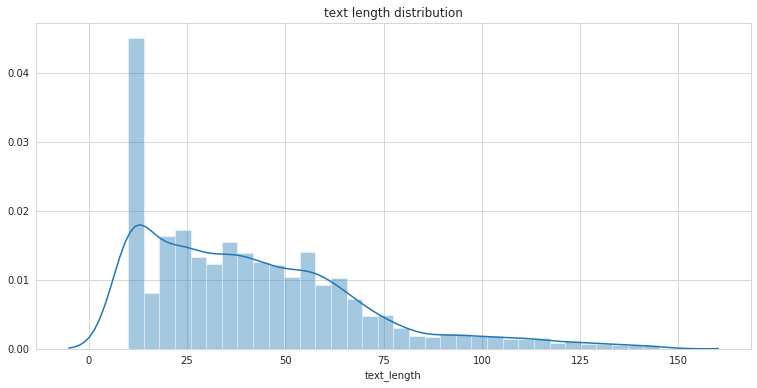

In [0]:
#Let's remove from the 95% percentile onwards to better appreciate the histogram:

quantile_95 = df['text_length'].quantile(0.95)
df_95 = df[df['text_length'] < quantile_95]
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['text_length']).set_title('text length distribution');

In [0]:
#We can get the number of text with more than 1,000 characters:
df_more10k = df[df['text_length'] > 100]
len(df_more10k)

5

In [0]:
df_more10k['text'].iloc[0]


'[\'EF 55%), COPD, CVA X2, UGI BLEED, HTN, OBESITY, S/P LEFT CEA [**2138-7-30**]. PT WENT TO [**Hospital1 2**] ER ON [**2138-8-1**] WITH 2 DAY  H/O OF RUQ PAIN,N/V, FEVER, CHILLS AND SWEATS AND ALSO C/O DIAHERRA. PT LIPASE 1365, AMYLASE 571. CT SCAN SHOWED DILATED GB WITH DILATED DUCTS. PT ADMITTED TO SICU ON [**2138-8-2**] FOR ANTIBIOTIC, AND IV HYDRATION.  YESTERDAY, OT STARTED IV LOPRESSOR FOR HR AND BP CONTROL, PT ON CEFTRIAXONE, AND FLAGYL FOR ANTIBIOTIC.  PT WITH 2 EPOSIDES OF DIAHERRA, GUIAC POSITIVE, HAD ON EPOSIDE OF NAUSEA WHICH WAS TX WITH ZOFRAN WITH GOOD EFFECT, PT [**Date Range 10**] MORPHINE IV FOR ABD PAIN WITH GOOD EFFECT.  REPEAT HCT YESTERDAY 30.9.  NUERO: PT AWAKE, ALERT AND ORIENTED X3, BOTH PUPILS EQUAL AND REACTIVE TO LIGHT. HAND GRASP STRONG, RIGHT SIDE IS WEAKER THAN LEFT. PT SPEECH IS THICK AND PT TALKS SLOW, PT STATES THIS IS HER BASELINE "THIS IS FROM A PRIOR STROKE".  CARDS: PT IN SR SBP 140-170, PT IS [**Name (NI) 2064**] 5MG OF IV LOPRESSOR ATC. PULM: LUN

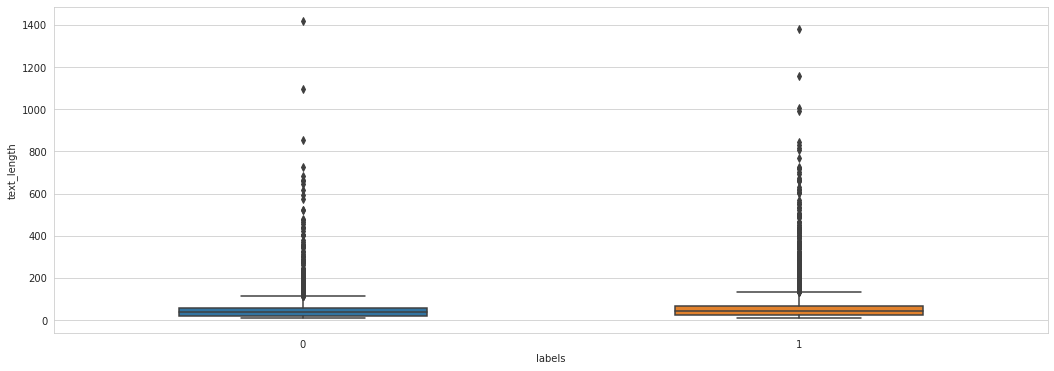

In [0]:
#Let's now plot a boxplot:
plt.figure(figsize=(17.8,6))

sns.boxplot(data=df, x='labels', y='text_length', width=.5);

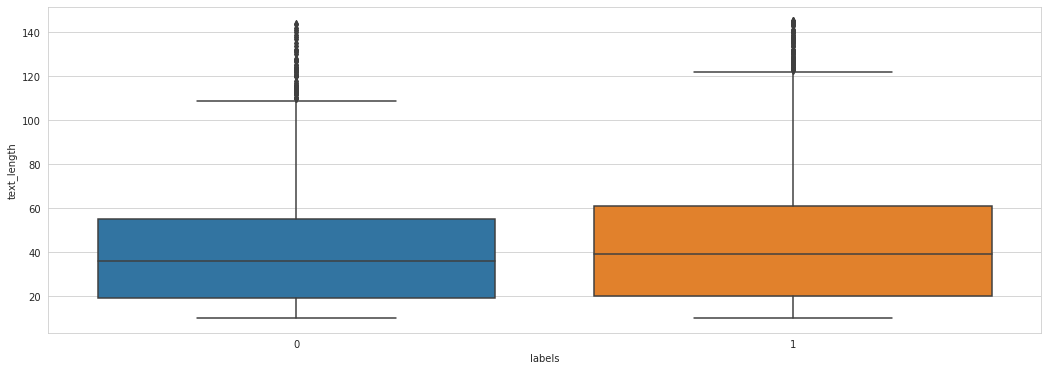

In [0]:
#Now, let's remove the larger documents for better comprehension:
plt.figure(figsize=(17.8,6))
sns.boxplot(data=df_95, x='labels', y='text_length');


In [0]:
#We'll turn onto the Feature Engineering section.
#We'll save the dataset:


with open('dataset.pickle', 'wb') as output:
    pickle.dump(df, output)


## Feature Engineering
The next step is to create features from the raw text so we can train the machine learning models. The steps followed are:

Text Cleaning and Preparation: cleaning of special characters, downcasing, punctuation signs. possessive pronouns and stop words removal and lemmatization.
Label coding: creation of a dictionary to map each category to a code.
Train-test split: to test the models on unseen data.
Text representation: use of TF-IDF scores to represent text.

In [0]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

In [0]:
path_df = "dataset.pickle"

with open(path_df, 'rb') as data:
    df = pickle.load(data)

In [0]:
df.head()


,EF_Label,Sentence_with_EF,labels,text,text_length
0,0.0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...",0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...",104
1,1.0,['EF 40%)'],1,['EF 40%)'],11
2,1.0,"['EF 35%)', 'EF 35%), AICD p/w SOB and']",1,"['EF 35%)', 'EF 35%), AICD p/w SOB and']",40
3,1.0,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']",1,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']",46
4,0.0,['EF 70%) The right ventricular free wall is'],0,['EF 70%) The right ventricular free wall is'],46


## 1. Text cleaning and preparation
1.1. Special character cleaning
We can see the following special characters:

\r

\n

\ before possessive pronouns (government's = government\'s)

\ before possessive pronouns 2 (Yukos' = Yukos\')

" when quoting text

In [0]:
# \r and \n
df['Content_Parsed_1'] = df['text'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

In [0]:
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')

## 1.2. Upcase/downcase
We'll downcase the texts because we want, for example, Football and football to be the same word.

In [0]:
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()

## 1.3. Punctuation signs
Punctuation signs won't have any predicting power, so we'll just get rid of them.

In [0]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
#By doing this we are messing up with some numbers,     

## 1.4. Possessive pronouns
We'll also remove possessive pronoun terminations:

In [0]:
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")


## 1.5. Stemming and Lemmatization
Since stemming can produce output words that don't exist, we'll only use a lemmatization process at this moment. Lemmatization takes into consideration the morphological analysis of the words and returns words that do exist, so it will be more useful for us.

In [0]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to /home/z/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/z/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [0]:
#In order to lemmatize, we have to iterate through every word:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)



In [0]:
df['Content_Parsed_5'] = lemmatized_text_list
#Although lemmatization doesn't work perfectly in all cases

## 1.6. Stop words
### Downloading the stop words list


In [0]:
nltk.download('stopwords')

# Loading the stop words in english
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/z/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#We can now loop through all the stop words:

df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')


We have some dobule/triple spaces between words because of the replacements. However, it's not a problem because we'll tokenize by the spaces later.

As an example, we'll show an original textand its modifications throughout the process:

In [0]:
df.loc[5]['text']


"['EF 60%']"

In [0]:
#Special character cleaning

df.loc[5]['Content_Parsed_1']


"['EF 60%']"

In [0]:
#Upcase/downcase

df.loc[5]['Content_Parsed_2']


"['ef 60%']"

In [0]:
#Punctuation signs
df.loc[5]['Content_Parsed_3']


"['ef 60%']"

In [0]:
#Possessive pronouns
df.loc[5]['Content_Parsed_4']


"['ef 60%']"

In [0]:
#Stemming and Lemmatization
df.loc[5]['Content_Parsed_5']


"['ef 60%']"

In [0]:
#Stop words
df.loc[5]['Content_Parsed_6']


"['ef 60%']"

In [0]:
df.head(10)


,EF_Label,Sentence_with_EF,labels,text,text_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
0,0.0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...",0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...",104,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...","['ef 63%), ^chol, hypothyroidism, htn,', 'ef 6...",['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...
1,1.0,['EF 40%)'],1,['EF 40%)'],11,['EF 40%)'],['ef 40%)'],['ef 40%)'],['ef 40%)'],['ef 40%)'],['ef 40%)']
2,1.0,"['EF 35%)', 'EF 35%), AICD p/w SOB and']",1,"['EF 35%)', 'EF 35%), AICD p/w SOB and']",40,"['EF 35%)', 'EF 35%), AICD p/w SOB and']","['ef 35%)', 'ef 35%), aicd p/w sob and']",['ef 35%)' 'ef 35%) aicd p/w sob and'],['ef 35%)' 'ef 35%) aicd p/w sob and'],['ef 35%)' 'ef 35%) aicd p/w sob and'],['ef 35%)' 'ef 35%) aicd p/w sob ']
3,1.0,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']",1,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']",46,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']","['ef 28%.', 'ef 28%, akinetic apex, lv mural']",['ef 28%' 'ef 28% akinetic apex lv mural'],['ef 28%' 'ef 28% akinetic apex lv mural'],['ef 28%' 'ef 28% akinetic apex lv mural'],['ef 28%' 'ef 28% akinetic apex lv mural']
4,0.0,['EF 70%) The right ventricular free wall is'],0,['EF 70%) The right ventricular free wall is'],46,['EF 70%) The right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) right ventricular free wall ']
5,0.0,['EF 60%'],0,['EF 60%'],10,['EF 60%'],['ef 60%'],['ef 60%'],['ef 60%'],['ef 60%'],['ef 60%']
6,1.0,"['EF 30%, moderate MR, and moderate']",1,"['EF 30%, moderate MR, and moderate']",37,"['EF 30%, moderate MR, and moderate']","['ef 30%, moderate mr, and moderate']",['ef 30% moderate mr and moderate'],['ef 30% moderate mr and moderate'],['ef 30% moderate mr and moderate'],['ef 30% moderate mr moderate']
7,1.0,"['EF 20%,', 'EF 20%, PVD s/p R BKA with']",1,"['EF 20%,', 'EF 20%, PVD s/p R BKA with']",41,"['EF 20%,', 'EF 20%, PVD s/p R BKA with']","['ef 20%,', 'ef 20%, pvd s/p r bka with']",['ef 20%' 'ef 20% pvd s/p r bka with'],['ef 20%' 'ef 20% pvd s/p r bka with'],['ef 20%' 'ef 20% pvd s/p r bka with'],['ef 20%' 'ef 20% pvd /p r bka ']
8,1.0,"['EF 30%). No masses or', 'EF 65%) presents wi...",1,"['EF 30%). No masses or', 'EF 65%) presents wi...",124,"['EF 30%). No masses or', 'EF 65%) presents wi...","['ef 30%). no masses or', 'ef 65%) presents wi...",['ef 30%) no masses or' 'ef 65%) presents with...,['ef 30%) no masses or' 'ef 65%) presents with...,['ef 30%) no mass or' 'ef 65%) present with ac...,['ef 30%) mass ' 'ef 65%) present acute onse...
9,1.0,['EF 50%). Right ventricular chamber size and ...,1,['EF 50%). Right ventricular chamber size and ...,64,['EF 50%). Right ventricular chamber size and ...,['ef 50%). right ventricular chamber size and ...,['ef 50%) right ventricular chamber size and f...,['ef 50%) right ventricular chamber size and f...,['ef 50%) right ventricular chamber size and f...,['ef 50%) right ventricular chamber size free...


In [0]:
list_columns = ["labels", "Content_Parsed_6"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [0]:
df.head()


,labels,Content_Parsed
0,0,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...
1,1,['ef 40%)']
2,1,['ef 35%)' 'ef 35%) aicd p/w sob ']
3,1,['ef 28%' 'ef 28% akinetic apex lv mural']
4,0,['ef 70%) right ventricular free wall ']


#2. Label coding
#We'll create a dictionary with the label codification:
category_codes = {
    'Communication': 0,
    'Compassion': 1,
    'Diversity': 2,
    'Flexible': 3,
    'Humility': 4,
    'Leadership': 5,
    'MP commitment': 6,
    'Self-aware': 7,
    'Well-Rounded': 8,
    'initiative': 9,
    'red flag': 10,
    'superlative': 11    
}

# Category mapping
df['Category_Code'] = df['Class']
df = df.replace({'Category_Code':category_codes})

In [0]:
# Category mapping
df['category_codes'] = df['labels']


In [0]:
df.head(20)

,labels,Content_Parsed,category_codes
0,0,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,0
1,1,['ef 40%)'],1
2,1,['ef 35%)' 'ef 35%) aicd p/w sob '],1
3,1,['ef 28%' 'ef 28% akinetic apex lv mural'],1
4,0,['ef 70%) right ventricular free wall '],0
5,0,['ef 60%'],0
6,1,['ef 30% moderate mr moderate'],1
7,1,['ef 20%' 'ef 20% pvd /p r bka '],1
8,1,['ef 30%) mass ' 'ef 65%) present acute onse...,1
9,1,['ef 50%) right ventricular chamber size free...,1


## 3. Train - test split
We'll set apart a test set to prove the quality of our models. We'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['category_codes'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## 4. Text representation
We have various options:

### Count Vectors as features
### TF-IDF Vectors as features
### Word Embeddings as features
### Text / NLP based features
### Topic Models as features
We'll use TF-IDF Vectors as features.

We have to define the different parameters:

ngram_range: We want to consider both unigrams and bigrams.
max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [0]:
#It needs to be mentioned that we are implicitly scaling our data when representing it as TF-IDF features with the argument norm.
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300


We have chosen these values as a first approximation. Since the models that we develop later have a very good predictive power, we'll stick to these values. But it has to be mentioned that different combinations could be tried in order to improve even more the accuracy of the models.

In [0]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(5692, 300)
(1423, 300)


Please note that we have fitted and then transformed the training set, but we have only transformed the test set.

We can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category:

In [0]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(df.category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# '0' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '8' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 6

# '100' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '101' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '102' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '103' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '104' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '105' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '106' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '107' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '108' category:
  . Most correlated unigrams:


# '199' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '200' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '201' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '202' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '203' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '204' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '205' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '206' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '207' category:
  . Most correlated unigrams:


# '272' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '273' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '274' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '275' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '276' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '277' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '278' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '279' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '280' category:
  . Most correlated unigrams:


# '363' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '364' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '365' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '366' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '367' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '368' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '369' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '370' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '371' category:
  . Most correlated unigrams:


# '447' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '448' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '449' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '450' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '451' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '452' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '453' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '454' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '455' category:
  . Most correlated unigrams:


# '533' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '534' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '535' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '536' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '537' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '538' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '539' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '540' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '541' category:
  . Most correlated unigrams:


# '619' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '620' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '621' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '622' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '623' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '624' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '625' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '626' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '627' category:
  . Most correlated unigrams:


# '709' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '710' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '711' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '712' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '713' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '714' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '715' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '716' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '717' category:
  . Most correlated unigrams:


# '798' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '799' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '800' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '801' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '802' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '803' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '804' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '805' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '806' category:
  . Most correlated unigrams:


# '883' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '884' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '885' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '886' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '887' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '888' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '889' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '890' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '891' category:
  . Most correlated unigrams:


# '965' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '966' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '967' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '968' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '969' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '970' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '971' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '972' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '973' category:
  . Most correlated unigrams:


# '1044' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1045' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1046' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1047' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1048' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1049' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1050' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1051' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1052' category:
  . Most correlated u

# '1131' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1132' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1133' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1134' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1135' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1136' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1137' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1138' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1139' category:
  . Most correlated u

# '1215' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1216' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1217' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1218' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1219' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1220' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1221' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1222' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1223' category:
  . Most correlated u

# '1303' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1304' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1305' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1306' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1307' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1308' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1309' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1310' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1311' category:
  . Most correlated u

# '1383' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1384' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1385' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1386' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1387' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1388' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1389' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1390' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1391' category:
  . Most correlated u

# '1463' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1464' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1465' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1466' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1467' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1468' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1469' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1470' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1471' category:
  . Most correlated u

# '1553' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1554' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1555' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1556' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1557' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1558' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1559' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1560' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1561' category:
  . Most correlated u

# '1642' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1643' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1644' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1645' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1646' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1647' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1648' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1649' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1650' category:
  . Most correlated u

# '1722' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1723' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1724' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1725' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1726' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1727' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1728' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1729' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1730' category:
  . Most correlated u

# '1805' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1806' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1807' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1808' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1809' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1810' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1811' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1812' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1813' category:
  . Most correlated u

# '1893' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1894' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1895' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1896' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1897' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1898' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1899' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1900' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1901' category:
  . Most correlated u

# '1982' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1983' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1984' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1985' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1986' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1987' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1988' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1989' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '1990' category:
  . Most correlated u

# '2080' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2081' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2082' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2083' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2084' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2085' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2086' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2087' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2088' category:
  . Most correlated u

# '2182' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2183' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2184' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2185' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2186' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2187' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2188' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2189' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2190' category:
  . Most correlated u

# '2264' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2265' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2266' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2267' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2268' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2269' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2270' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2271' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2272' category:
  . Most correlated u

# '2344' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2345' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2346' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2347' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2348' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2349' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2350' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2351' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2352' category:
  . Most correlated u

# '2427' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2428' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2429' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2430' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2431' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2432' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2433' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2434' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2435' category:
  . Most correlated u

# '2518' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2519' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2520' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2521' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2522' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2523' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2524' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2525' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2526' category:
  . Most correlated u

# '2592' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2593' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2594' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2595' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2596' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2597' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2598' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2599' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2600' category:
  . Most correlated u

# '2679' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2680' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2681' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2682' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2683' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2684' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2685' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2686' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2687' category:
  . Most correlated u

# '2767' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2768' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2769' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2770' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2771' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2772' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2773' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2774' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2775' category:
  . Most correlated u

# '2854' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2855' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2856' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2857' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2858' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2859' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2860' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2861' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2862' category:
  . Most correlated u

# '2945' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2946' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2947' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2948' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2949' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2950' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2951' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2952' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '2953' category:
  . Most correlated u

# '3036' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3037' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3038' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3039' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3040' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3041' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3042' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3043' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3044' category:
  . Most correlated u

# '3126' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3127' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3128' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3129' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3130' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3131' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3132' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3133' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3134' category:
  . Most correlated u

# '3208' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3209' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3210' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3211' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3212' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3213' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3214' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3215' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3216' category:
  . Most correlated u

# '3298' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3299' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3300' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3301' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3302' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3303' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3304' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3305' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3306' category:
  . Most correlated u

# '3374' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3375' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3376' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3377' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3378' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3379' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3380' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3381' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3382' category:
  . Most correlated u

# '3462' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3463' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3464' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3465' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3466' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3467' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3468' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3469' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3470' category:
  . Most correlated u

# '3557' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3558' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3559' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3560' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3561' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3562' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3563' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3564' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3565' category:
  . Most correlated u

# '3647' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3648' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3649' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3650' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3651' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3652' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3653' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3654' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3655' category:
  . Most correlated u

# '3723' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3724' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3725' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3726' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3727' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3728' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3729' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3730' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3731' category:
  . Most correlated u

# '3798' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3799' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3800' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3801' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3802' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3803' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3804' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3805' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3806' category:
  . Most correlated u

# '3876' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3877' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3878' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3879' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3880' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3881' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3882' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3883' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3884' category:
  . Most correlated u

# '3947' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3948' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3949' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3950' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3951' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3952' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3953' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3954' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '3955' category:
  . Most correlated u

# '4049' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4050' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4051' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4052' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4053' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4054' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4055' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4056' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4057' category:
  . Most correlated u

# '4119' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4120' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4121' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4122' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4123' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4124' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4125' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4126' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4127' category:
  . Most correlated u

# '4212' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4213' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4214' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4215' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4216' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4217' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4218' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4219' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4220' category:
  . Most correlated u

# '4302' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4303' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4304' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4305' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4306' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4307' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4308' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4309' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4310' category:
  . Most correlated u

# '4387' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4388' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4389' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4390' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4391' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4392' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4393' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4394' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4395' category:
  . Most correlated u

# '4465' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4466' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4467' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4468' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4469' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4470' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4471' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4472' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4473' category:
  . Most correlated u

# '4548' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4549' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4550' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4551' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4552' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4553' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4554' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4555' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4556' category:
  . Most correlated u

# '4623' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4624' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4625' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4626' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4627' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4628' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4629' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4630' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4631' category:
  . Most correlated u

# '4712' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4713' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4714' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4715' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4716' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4717' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4718' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4719' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4720' category:
  . Most correlated u

# '4792' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4793' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4794' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4795' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4796' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4797' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4798' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4799' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4800' category:
  . Most correlated u

# '4873' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4874' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4875' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4876' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4877' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4878' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4879' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4880' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4881' category:
  . Most correlated u

# '4947' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4948' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4949' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4950' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4951' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4952' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4953' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4954' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '4955' category:
  . Most correlated u

# '5029' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5030' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5031' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5032' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5033' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5034' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5035' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5036' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5037' category:
  . Most correlated u

# '5107' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5108' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5109' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5110' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5111' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5112' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5113' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5114' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5115' category:
  . Most correlated u

# '5195' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5196' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5197' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5198' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5199' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5200' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5201' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5202' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5203' category:
  . Most correlated u

# '5293' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5294' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5295' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5296' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5297' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5298' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5299' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5300' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5301' category:
  . Most correlated u

# '5376' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5377' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5378' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5379' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5380' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5381' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5382' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5383' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5384' category:
  . Most correlated u

# '5465' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5466' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5467' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5468' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5469' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5470' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5471' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5472' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5473' category:
  . Most correlated u

# '5555' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5556' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5557' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5558' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5559' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5560' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5561' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5562' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5563' category:
  . Most correlated u

# '5644' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5645' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5646' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5647' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5648' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5649' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5650' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5651' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5652' category:
  . Most correlated u

# '5726' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5727' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5728' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5729' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5730' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5731' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5732' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5733' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5734' category:
  . Most correlated u

# '5814' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5815' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5816' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5817' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5818' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5819' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5820' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5821' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5822' category:
  . Most correlated u

# '5901' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5902' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5903' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5904' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5905' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5906' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5907' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5908' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5909' category:
  . Most correlated u

# '5984' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5985' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5986' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5987' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5988' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5989' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5990' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5991' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '5992' category:
  . Most correlated u

# '6057' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6058' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6059' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6060' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6061' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6062' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6063' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6064' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6065' category:
  . Most correlated u

# '6146' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6147' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6148' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6149' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6150' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6151' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6152' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6153' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6154' category:
  . Most correlated u

# '6239' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6240' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6241' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6242' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6243' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6244' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6245' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6246' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6247' category:
  . Most correlated u

# '6319' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6320' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6321' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6322' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6323' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6324' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6325' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6326' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6327' category:
  . Most correlated u

# '6418' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6419' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6420' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6421' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6422' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6423' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6424' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6425' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6426' category:
  . Most correlated u

# '6517' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6518' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6519' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6520' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6521' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6522' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6523' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6524' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6525' category:
  . Most correlated u

# '6609' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6610' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6611' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6612' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6613' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6614' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6615' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6616' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6617' category:
  . Most correlated u

# '6699' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6700' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6701' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6702' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6703' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6704' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6705' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6706' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6707' category:
  . Most correlated u

# '6779' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6780' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6781' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6782' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6783' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6784' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6785' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6786' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6787' category:
  . Most correlated u

# '6869' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6870' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6871' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6872' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6873' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6874' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6875' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6876' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6877' category:
  . Most correlated u

# '6962' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6963' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6964' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6965' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6966' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6967' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6968' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6969' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '6970' category:
  . Most correlated u

# '7052' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7053' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7054' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7055' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7056' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7057' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7058' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7059' category:
  . Most correlated unigrams:
. 30
. 50
. 70
. 60
. 55
  . Most correlated bigrams:
. ef 60
. ef 55

# '7060' category:
  . Most correlated u

In [0]:
bigrams


['ventricular cavity',
 'mild mr',
 'leave ventricular',
 'name stitle',
 'transfer hospital1',
 'mr tr',
 'aortic valve',
 'diastolic dysfunction',
 'titles last',
 'last name',
 'mr first',
 'first name',
 'name ni',
 'name titles',
 'see leave',
 'biv icd',
 'leave ventricle',
 'motion normal',
 'image suggest',
 'wall motion',
 'doppler image',
 'secondary hypokinesis',
 'suboptimal technical',
 'doppler imaging',
 '55 mr',
 '35 ef',
 '50 mild',
 '75 right',
 '40 ef',
 '70 due',
 'fraction 30',
 '45 ef',
 '20 ef',
 '60 mild',
 'thrombi see',
 '30 ef',
 '25 ef',
 'ventricular free',
 '60 ventricular',
 '70 mass',
 'due suboptimal',
 '55 mild',
 '60 tissue',
 'mass thrombi',
 'size free',
 'defect right',
 'ejection fraction',
 'tissue doppler',
 'chamber size',
 'septal defect',
 '50 secondary',
 'ventricular septal',
 'free wall',
 '60 mass',
 'ef 10',
 '70 tissue',
 '50 right',
 '65 right',
 '60 right',
 'ef 80',
 'ventricular chamber',
 '70 ventricular',
 'right ventricular',
 'e

We can see there are 24. This means the unigrams have more correlation with the category than the bigrams, and since we're restricting the number of features to the most representative 300, only a few bigrams are being considered.

Let's save the files we'll need in the next steps:

In [0]:
# X_train
with open('Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('Pickles/df.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)


## Model Training
Once we have our feature vectors built, we'll try several machine learning classification models in order to find which one performs best on our data. We will try with the following models:

Baseline Classifier

Random Forest

Support Vector Machine

K Nearest Neighbors

Multinomial Naïve Bayes

Multinomial Logistic Regression

Gradient Boosting

The methodology used to train each model is as follows:

First of all, we'll decide which hyperparameters we want to tune.

Secondly, we'll define the metric we'll get when measuring the performance of a model. In this case, we'll use the accuracy.

We'll perform a Randomized Search Cross Validation process in order to find the hyperparameter region in which we get higher values of accuracy.

Once we find that region, we'll use a Grid Search Cross Validation process to exhaustively find the best combination of hyperparameters.

Once we obtain the best combination of hyperparameters, we'll obtain the accuracy on the training data and the test data, the classification report and the confusion matrix.

Finally, we'll calculate the accuracy of a model with default hyperparameters, to see if we have achieved better results by hyperparameter tuning.




## Baseline Classifier
In order to fix a baseline to be conscious about whether we are developing useful models or not, a baseline classifier that always predicted the majority class would be the simplest classifier we could build.

The majority class represents a 23% of the whole dataset. For that reason, that would be the accuracy of a majority class classifier.

In [0]:
#Random Forest
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [0]:
# Dataframe
path_df = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [0]:
#Let's check the dimension of our feature vectors:

print(features_train.shape)
print(features_test.shape)

(5692, 300)
(1423, 300)


In [0]:
#Cross-Validation for Hyperparameter tuning
#First, we can see what hyperparameters the model has:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}



We'll tune the following ones:

n_estimators = number of trees in the forest.

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

In [0]:
#Randomized Search Cross Validation
#We first need to define the grid:

# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [0]:
#Then, we'll perform the Random Search:

# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
#We can see the best hyperparameters resulting from the Random Search:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.9689032597084966


In [0]:
#Grid Search Cross Validation¶
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sampl...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  

In [0]:
#The best hyperparameters turn out to be:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.9700195139258471


In [0]:
#Let's save the model in best_rfc:

best_rfc = grid_search.best_estimator_

best_rfc


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [0]:
#Model fit and performance
#Now, we can fit the model to our training data:
best_rfc.fit(features_train, labels_train)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [0]:
#And get the predictions:
rfc_pred = best_rfc.predict(features_test)


The conditional class probabilities can be obtained by typing:

rfc_pred = best_rfc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

Training accuracy

In [0]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9801475755446241


In [0]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.9683766690091357


In [0]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       658
           1       0.98      0.96      0.97       765

    accuracy                           0.97      1423
   macro avg       0.97      0.97      0.97      1423
weighted avg       0.97      0.97      0.97      1423



In [0]:
df.head()

,labels,Content_Parsed,category_codes
0,0,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,0
1,1,['ef 40%)'],1
2,1,['ef 35%)' 'ef 35%) aicd p/w sob '],1
3,1,['ef 28%' 'ef 28% akinetic apex lv mural'],1
4,0,['ef 70%) right ventricular free wall '],0


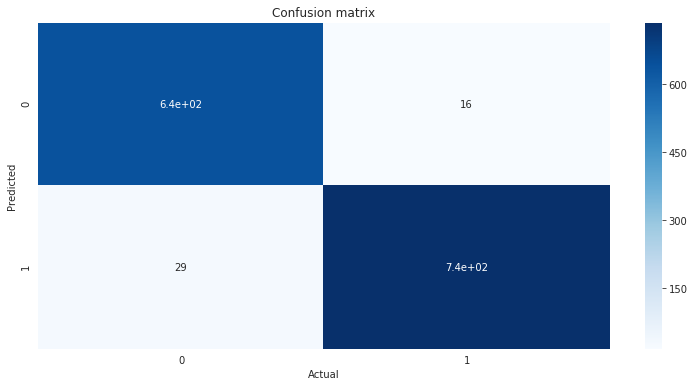

In [0]:
#Confusion matrix
aux_df = df[['labels', 'category_codes']].drop_duplicates().sort_values('category_codes')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()



At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

In [0]:
#However, the code below could do this task:

#features_time = features_train
#elapsed_list = []
#for i in range(0,10):
#
#    start = time.time()
#    predictions = best_lrc.predict(features_time)
#    end = time.time()
#    elapsed = end - start
#    elapsed_list.append(elapsed)

#mean_time_elapsed = np.mean(elapsed_list)

In [0]:
#Let's see if the hyperparameter tuning process has returned a better model:

base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9676739283204497

In [0]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.9683766690091357

In [0]:
#We'll create a dataset with a model summary to compare models:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])


In [0]:
df_models_rfc


,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.980148,0.968377


In [0]:
#Let's save the model and this dataset:
with open('Models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('Models/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)



### Support Vector Machine


In [0]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
# Dataframe
path_df = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [0]:
print(features_train.shape)
print(features_test.shape)

(5692, 300)
(1423, 300)


In [0]:
#Cross-Validation for Hyperparameter tuning

#First, we can see what hyperparameters the model has:

svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


We'll tune the following ones:

C: Penalty parameter C of the error term.

kernel: Specifies the kernel type to be used in the algorithm.

gamma: Kernel coefficient.

degree: Degree of the polynomial kernel function.

Randomized Search Cross Validation

We first need to define the grid:

In [0]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [0]:
#Then, we'll perform the Random Search:

# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 57.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=8,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_s

In [0]:
#We can see the best hyperparameters resulting from the Random Search:

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'linear', 'gamma': 0.0001, 'degree': 3, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.9430776303849143


After that, we can do a more exhaustive search centered in those values:

Grid Search Cross Validation

In [0]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 29.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=8, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated'...one,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability':

In [0]:
#The best hyperparameters turn out to be:

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)


The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.961149547631719


In [0]:
#Let's save the model in best_svc:

best_svc = grid_search.best_estimator_


In [0]:
best_svc

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
#We now know the best SVM model. Let's fit it and see how it performs:

#Model fit and performance

#Now, we can fit the model to our training data:
best_svc.fit(features_train, labels_train)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
#And get the predictions:
svc_pred = best_svc.predict(features_test)


The conditional class probabilities can be obtained by typing:

svc_pred = best_svc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

Training accuracy

In [0]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.9667955024595924


In [0]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.966268446943078


In [0]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       658
           1       0.95      0.99      0.97       765

    accuracy                           0.97      1423
   macro avg       0.97      0.96      0.97      1423
weighted avg       0.97      0.97      0.97      1423



In [0]:
df.head()

,labels,Content_Parsed,category_codes
0,0,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,0
1,1,['ef 40%)'],1
2,1,['ef 35%)' 'ef 35%) aicd p/w sob '],1
3,1,['ef 28%' 'ef 28% akinetic apex lv mural'],1
4,0,['ef 70%) right ventricular free wall '],0


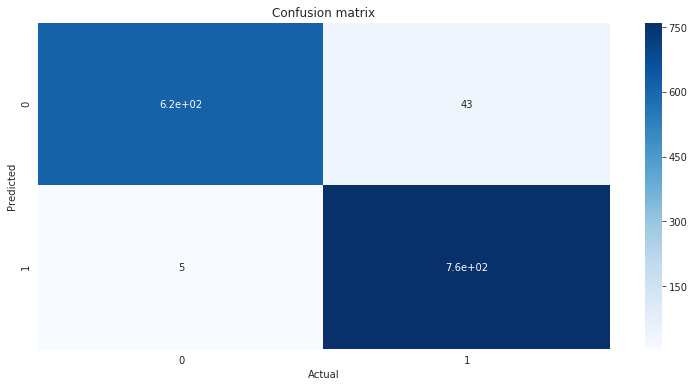

In [0]:
#Confusion matrix
aux_df = df[['labels', 'category_codes']].drop_duplicates().sort_values('category_codes')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()


In [0]:
#Let's see if the hyperparameter tuning process has returned a better model:

base_model = svm.SVC(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9655657062543921

In [0]:
best_svc.fit(features_train, labels_train)
accuracy_score(labels_test, best_svc.predict(features_test))

0.966268446943078

In [0]:
#We'll create a dataset with a model summary to compare models:

d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])

In [0]:
df_models_svc


,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.966796,0.966268


In [0]:
with open('Models/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('Models/df_models_svc.pickle', 'wb') as output:
    pickle.dump(df_models_svc, output)

## K Nearest Neighbors


In [0]:

import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
# Dataframe
path_df = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [0]:
#Cross-Validation for Hyperparameter tuning
#First, we can see what hyperparameters the model has:
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


We'll tune the following ones:

K: Number of neighbors to use by default for queries.
In this case, since there is only one hyperparameter, we'll perform an exhaustive search directly:

Grid Search Cross Validation
We first need to define the grid:

In [0]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .28, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 15.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.28, train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                         51, 56, 61, 66, 71, 76, 81, 86, 91, 96,
                                         101, 106, 111, 116, 121, 127, 132, 137,
                                         142, 147, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [0]:
#The best parameters turn out to be:

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 263}

The mean accuracy of a model with these hyperparameters is:
0.9544123797574237


In [0]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   56.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [0]:
#The best parameters turn out to be:

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 11}

The mean accuracy of a model with these hyperparameters is:
0.9292176689728578


In [0]:
#Let's save the model in best_knnc:
best_knnc = grid_search.best_estimator_




In [0]:
best_knnc


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

We now know the best KNN model. Let's fit it and see how it performs:

Model fit and performance¶
Now, we can fit the model to our training data:

In [0]:
best_knnc.fit(features_train, labels_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [0]:
#And get the predictions:

knnc_pred = best_knnc.predict(features_test)


The conditional class probabilities can be obtained by typing:

knnc_pred = best_knnc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

Training accuracy

In [0]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.9443078004216444


In [0]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.9388615600843289


In [0]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       658
           1       0.93      0.96      0.94       765

    accuracy                           0.94      1423
   macro avg       0.94      0.94      0.94      1423
weighted avg       0.94      0.94      0.94      1423



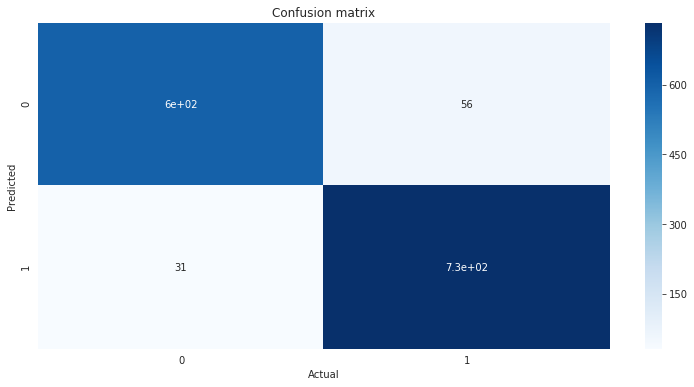

In [0]:
ux_df = df[['labels', 'category_codes']].drop_duplicates().sort_values('category_codes')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

features_time = features_train
elapsed_list = []
for i in range(0,10):

    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
Let's see if the hyperparameter tuning process has returned a better model:

In [0]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9311314125087843

In [0]:
best_knnc.fit(features_train, labels_train)
accuracy_score(labels_test, best_knnc.predict(features_test))

0.9388615600843289


We can see that the default model (with 5 Nearest Neighbors) performs better. However, in our Grid Search Cross Validation process we tried with that number of neighbors. The reason why we may be getting this result is because de Grid Search performs a Cross Validation scheme, while this last comparison uses all training data.

We'll create a dataset with a model summary to compare models:



In [0]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train, best_knnc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, knnc_pred)
}

df_models_knnc = pd.DataFrame(d, index=[0])


In [0]:
df_models_knnc


,Model,Training Set Accuracy,Test Set Accuracy
0,KNN,0.944308,0.938862


In [0]:
with open('Models/best_knnc.pickle', 'wb') as output:
    pickle.dump(best_knnc, output)

with open('Models/df_models_knnc.pickle', 'wb') as output:
    pickle.dump(df_models_knnc, output)

## Multinomial Naïve Bayes


In [0]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
# Dataframe
path_df = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Cross-Validation for Hyperparameter tuning

In the case of the Multinomial Naïve Bayes, we will not tune any hyperparameter.

In [0]:
mnbc = MultinomialNB()
mnbc

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Let's fit it and see how it performs:

Model fit and performance

Now, we can fit the model to our training data:

In [0]:
mnbc.fit(features_train, labels_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
#And get the predictions:

mnbc_pred = mnbc.predict(features_test)


The conditional class probabilities can be obtained by typing:

mnbc_pred = mnbc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

Training accuracy

In [0]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

The training accuracy is: 
0.9455375966268447


In [0]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

The test accuracy is: 
0.9451862262825017


In [0]:
# Classification report
print("Classification report")
print(classification_report(labels_test,mnbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       658
           1       0.93      0.97      0.95       765

    accuracy                           0.95      1423
   macro avg       0.95      0.94      0.94      1423
weighted avg       0.95      0.95      0.95      1423



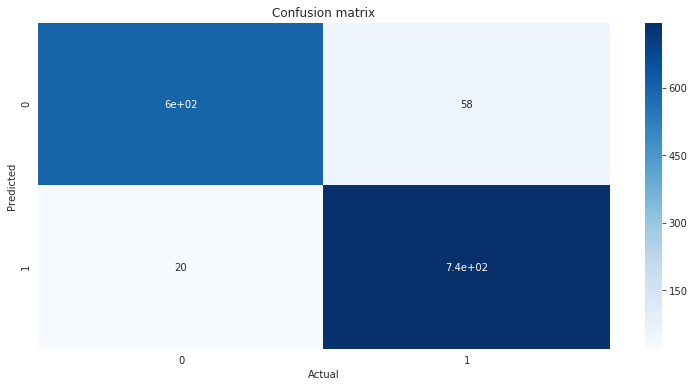

In [0]:
aux_df = df[['labels', 'category_codes']].drop_duplicates().sort_values('category_codes')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

features_time = features_train
elapsed_list = []
for i in range(0,10):

    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
We'll create a dataset with a model summary to compare models:

In [0]:
d = {
     'Model': 'Multinomial Naïve Bayes',
     'Training Set Accuracy': accuracy_score(labels_train, mnbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, mnbc_pred)
}

df_models_mnbc = pd.DataFrame(d, index=[0])

In [0]:
df_models_mnbc


,Model,Training Set Accuracy,Test Set Accuracy
0,Multinomial Naïve Bayes,0.945538,0.945186


In [0]:
with open('Models/best_mnbc.pickle', 'wb') as output:
    pickle.dump(mnbc, output)
    
with open('Models/df_models_mnbc.pickle', 'wb') as output:
    pickle.dump(df_models_mnbc, output)

## Multinomial Logistic Regression

In [0]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
# Dataframe
path_df = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [0]:
#Let's check the dimension of our feature vectors:
print(features_train.shape)
print(features_test.shape)

(5692, 300)
(1423, 300)


Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [0]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

C = Inverse of regularization strength. Smaller values specify stronger regularization.

multi_class = We'll choose multinomial because this is a multi-class problem.

solver = Algorithm to use in the optimization problem. For multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss.

class_weight: Weights associated with classes.

penalty: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

In [0]:
#Randomized Search Cross Validation
#We first need to define the grid:

# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [0]:
#Then, we'll perform the Random Search:

# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   35.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanc

In [0]:
#We can see the best hyperparameters resulting from the Random Search:

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.30000000000000004}

The mean accuracy of a model with these hyperparameters is:
0.9687272659268817


In [0]:
#After that, we can do a more exhaustive search centered in those values:

#Grid Search Cross Validation

# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   13.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0]

In [0]:
#The best hyperparameters turn out to be:

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.971261309207025


In [0]:
#Let's save the model in best_lrc:

best_lrc = grid_search.best_estimator_


In [0]:
best_lrc


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

We now know the best logistic regression model. Let's fit it and see how it performs:

Model fit and performance

Now, we can fit the model to our training data:

In [0]:
best_lrc.fit(features_train, labels_train)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

In [0]:
#And get the predictions:

lrc_pred = best_lrc.predict(features_test)


The conditional class probabilities can be obtained by typing:

lrc_pred = best_lrc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

Training accuracy

In [0]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.9764581869290232


In [0]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.9669711876317639


In [0]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       658
           1       0.98      0.96      0.97       765

    accuracy                           0.97      1423
   macro avg       0.97      0.97      0.97      1423
weighted avg       0.97      0.97      0.97      1423



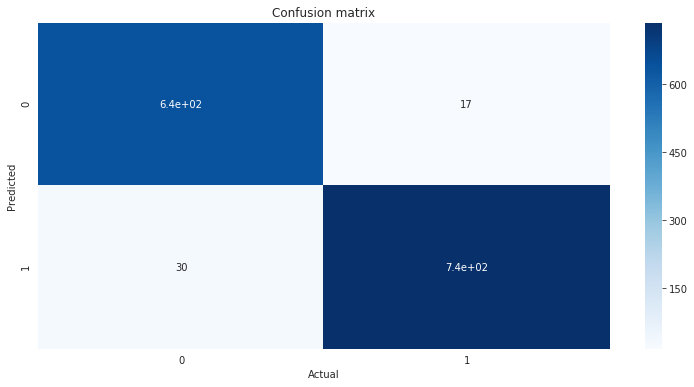

In [0]:
aux_df = df[['labels', 'category_codes']].drop_duplicates().sort_values('category_codes')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

features_time = features_train
elapsed_list = []
for i in range(0,10):

    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
Let's see if the hyperparameter tuning process has returned a better model:

In [0]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9655657062543921

In [0]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

0.9669711876317639

In [0]:
#We get approximately the same accuracy.

#We'll create a dataset with a model summary to compare models:

d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])

In [0]:
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.976458,0.966971


In [0]:
with open('Models/best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('Models/df_models_lrc.pickle', 'wb') as output:
    pickle.dump(df_models_lrc, output)

## Gradient Boosting Machine


In [0]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
# Dataframe
path_df = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/z/Documents/NLP/Jupyter/BMI/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [0]:
#Let's check the dimension of our feature vectors:


print(features_train.shape)
print(features_test.shape)


(5692, 300)
(1423, 300)


Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [0]:
gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

Tree-related hyperparameters:

n_estimators = number of trees in the forest.

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

Boosting-related hyperparameters:

learning_rate= learning rate shrinks the contribution of each tree by learning_rate.

subsample= the fraction of samples to be used for fitting the individual base learners.
Randomized Search Cross Validation

We first need to define the grid. Since we have a huge amount of hyperparameters, we'll try few values for each one.

In [0]:
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [0]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 44.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [0]:
#We can see the best hyperparameters resulting from the Random Search:

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.9657414818917118


In [0]:
#After that, we can do a more exhaustive search centered in those values:

#Grid Search Cross Validation

# Create the parameter grid based on the results of random search 
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samp...
                                                  tol=0.0001,
                                                  validation_fraction=0.1,
                 

In [0]:
#The best hyperparameters turn out to be:

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.9641653361717225


In [0]:
#Let's save the model in best_gbc:
best_gbc = grid_search.best_estimator_

In [0]:
best_gbc


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


We now know the best gradient boosting model. Let's fit it and see how it performs:

Model fit and performance

Now, we can fit the model to our training data:

In [0]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
#And get the predictions:
gbc_pred = best_gbc.predict(features_test)

The conditional class probabilities can be obtained by typing:

gbc_pred = best_gbc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

In [0]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

The training accuracy is: 
0.9868236120871399


In [0]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

The test accuracy is: 
0.9648629655657063


In [0]:
# Classification report
print("Classification report")
print(classification_report(labels_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       658
           1       0.97      0.96      0.97       765

    accuracy                           0.96      1423
   macro avg       0.96      0.97      0.96      1423
weighted avg       0.96      0.96      0.96      1423



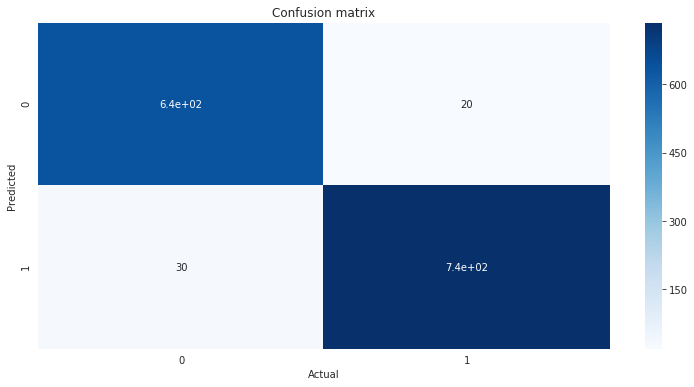

In [0]:
aux_df = df[['labels', 'category_codes']].drop_duplicates().sort_values('category_codes')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

features_time = features_train
elapsed_list = []
for i in range(0,10):

    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
Let's see if the hyperparameter tuning process has returned a better model:

In [0]:
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9690794096978215

In [0]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.9648629655657063

In [0]:
# We'll create a dataset with a model summary to compare models:
d = {
     'Model': 'Gradient Boosting',
     'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}

df_models_gbc = pd.DataFrame(d, index=[0])


In [0]:
df_models_gbc


,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,0.986824,0.964863


In [0]:
with open('Models/best_gbc.pickle', 'wb') as output:
    pickle.dump(best_gbc, output)
    
with open('Models/df_models_gbc.pickle', 'wb') as output:
    pickle.dump(df_models_gbc, output)

## Best Model Selection
Now that we have trained all the models, let's select the one we'll use for the application. We'll need to get the performance metrics generated in every model:

In [0]:
import pickle
import pandas as pd

In [0]:
path_pickles = "/home/z/Documents/NLP/Jupyter/BMI/Models/"

list_pickles = [
    "df_models_gbc.pickle",
    "df_models_knnc.pickle",
    "df_models_lrc.pickle",
    "df_models_mnbc.pickle",
    "df_models_rfc.pickle",
    "df_models_svc.pickle"
]

df_summary = pd.DataFrame()

for pickle_ in list_pickles:
    
    path = path_pickles + pickle_
    
    with open(path, 'rb') as data:
        df = pickle.load(data)

    df_summary = df_summary.append(df)

df_summary = df_summary.reset_index().drop('index', axis=1)

In [0]:
#Let's see the summary:
df_summary




,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,0.986824,0.964863
1,KNN,0.944308,0.938862
2,Logistic Regression,0.976458,0.966971
3,Multinomial Naïve Bayes,0.945538,0.945186
4,Random Forest,0.980148,0.968377
5,SVM,0.966796,0.966268


In [0]:
#And sort it by Test Set Accuracy:

df_summary.sort_values('Test Set Accuracy', ascending=False)


,Model,Training Set Accuracy,Test Set Accuracy
4,Random Forest,0.980148,0.968377
2,Logistic Regression,0.976458,0.966971
5,SVM,0.966796,0.966268
0,Gradient Boosting,0.986824,0.964863
3,Multinomial Naïve Bayes,0.945538,0.945186
1,KNN,0.944308,0.938862


## Interpretability to Text Classification models

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

import pandas as pd
df=pd.read_csv('last.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,id,text,EF_Label,Sentence_with_EF
0,2,2,13702,Admission Date: [**2119-5-4**] D...,0.0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6..."
1,11,11,1136,Admission Date: [**2192-4-19**] ...,1.0,['EF 40%)']
2,17,17,79900,Admission Date: [**2194-7-18**] ...,1.0,"['EF 35%)', 'EF 35%), AICD p/w SOB and']"
3,21,21,9805,Admission Date: [**2131-7-5**] D...,1.0,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']"
4,36,36,30812,Admission Date: [**2143-11-22**] ...,0.0,['EF 70%) The right ventricular free wall is']


In [0]:
from io import StringIO
col = ['EF_Label', 'Sentence_with_EF']
df = df[col]
#df = df[pd.notnull(df['text'])]
df.columns = ['EF_Label', 'Sentence_with_EF']
df['EF_Label'] = df['EF_Label'].factorize()[0]
#category_id_df = df[['Class', 'Class']].drop_duplicates().sort_values('labels')
#category_to_id = dict(category_id_df.values)
#id_to_category = dict(category_id_df[['labels', 'Class']].values)
df.head(10)

,EF_Label,Sentence_with_EF
0,0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6..."
1,1,['EF 40%)']
2,1,"['EF 35%)', 'EF 35%), AICD p/w SOB and']"
3,1,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']"
4,0,['EF 70%) The right ventricular free wall is']
5,0,['EF 60%']
6,1,"['EF 30%, moderate MR, and moderate']"
7,1,"['EF 20%,', 'EF 20%, PVD s/p R BKA with']"
8,1,"['EF 30%). No masses or', 'EF 65%) presents wi..."
9,1,['EF 50%). Right ventricular chamber size and ...


In [0]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

df['Content_Parsed_1'] = df['Sentence_with_EF'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
#By doing this we are messing up with some numbers,     
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()
#In order to lemmatize, we have to iterate through every word:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

[nltk_data] Downloading package punkt to /home/z/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/z/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


------------------------------------------------------------


In [0]:
df['Content_Parsed_5'] = lemmatized_text_list
#Although lemmatization doesn't work perfectly in all cases
nltk.download('stopwords')

# Loading the stop words in english
stop_words = list(stopwords.words('english'))
#We can now loop through all the stop words:

df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')
df.head()

[nltk_data] Downloading package stopwords to /home/z/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,EF_Label,Sentence_with_EF,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
0,0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...","['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...","['ef 63%), ^chol, hypothyroidism, htn,', 'ef 6...",['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...,['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...
1,1,['EF 40%)'],['EF 40%)'],['ef 40%)'],['ef 40%)'],['ef 40%)'],['ef 40%)'],['ef 40%)']
2,1,"['EF 35%)', 'EF 35%), AICD p/w SOB and']","['EF 35%)', 'EF 35%), AICD p/w SOB and']","['ef 35%)', 'ef 35%), aicd p/w sob and']",['ef 35%)' 'ef 35%) aicd p/w sob and'],['ef 35%)' 'ef 35%) aicd p/w sob and'],['ef 35%)' 'ef 35%) aicd p/w sob and'],['ef 35%)' 'ef 35%) aicd p/w sob and']
3,1,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']","['EF 28%.', 'EF 28%, akinetic apex, LV mural']","['ef 28%.', 'ef 28%, akinetic apex, lv mural']",['ef 28%' 'ef 28% akinetic apex lv mural'],['ef 28%' 'ef 28% akinetic apex lv mural'],['ef 28%' 'ef 28% akinetic apex lv mural'],['ef 28%' 'ef 28% akinetic apex lv mural']
4,0,['EF 70%) The right ventricular free wall is'],['EF 70%) The right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) the right ventricular free wall is'],['ef 70%) the right ventricular free wall is']


In [0]:
list_columns = ["EF_Label", "Sentence_with_EF", "Content_Parsed_6"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})
df.head()

,EF_Label,Sentence_with_EF,Content_Parsed
0,0,"['EF 63%), ^chol, hypothyroidism, htn,', 'EF 6...",['ef 63%) ^chol hypothyroidism htn' 'ef 63%) h...
1,1,['EF 40%)'],['ef 40%)']
2,1,"['EF 35%)', 'EF 35%), AICD p/w SOB and']",['ef 35%)' 'ef 35%) aicd p/w sob and']
3,1,"['EF 28%.', 'EF 28%, akinetic apex, LV mural']",['ef 28%' 'ef 28% akinetic apex lv mural']
4,0,['EF 70%) The right ventricular free wall is'],['ef 70%) the right ventricular free wall is']


In [0]:
# Creating train-test Split
X = df[['Content_Parsed']]
y = df[['EF_Label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# fitting the classifier
vec = CountVectorizer()
clf = LogisticRegressionCV()
pipe = make_pipeline(vec, clf)
pipe.fit(X_train.Content_Parsed, y_train.EF_Label)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=100, multi_class

In [0]:
from sklearn import metrics

def print_report(pipe):
    y_actuals = y_test['EF_Label']
    y_preds = pipe.predict(X_test['Content_Parsed'])
    report = metrics.classification_report(y_actuals, y_preds)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_actuals, y_preds)))

print_report(pipe)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.98      0.98      1155

    accuracy                           0.98      2135
   macro avg       0.98      0.98      0.98      2135
weighted avg       0.98      0.98      0.98      2135

accuracy: 0.982


In [0]:
for i, tag in enumerate(clf.classes_):
    coefficients = clf.coef_[i]
    weights = list(zip(vec.get_feature_names(),coefficients))
    print('Tag:',tag)
    print('Most Positive Coefficients:')
    print(sorted(weights,key=lambda x: -x[1])[:10])
    print('Most Negative Coefficients:')
    print(sorted(weights,key=lambda x: x[1])[:10])
    print("--------------------------------------")

Tag: 0
Most Positive Coefficients:
[('45', 8.68407305693009), ('51', 8.625297104877335), ('35', 7.6909816675756115), ('50', 6.851194425318436), ('30', 5.689844150940111), ('25', 5.405513280195321), ('20', 5.394969858765624), ('40', 5.293864719253952), ('15', 4.150526449901954), ('41', 4.00615083493475)]
Most Negative Coefficients:
[('65', -9.257594144255844), ('55', -7.051322724867963), ('60', -7.014815695795681), ('75', -6.556899460558695), ('59', -6.488493969144445), ('70', -6.0502375874023215), ('58', -6.047770948740433), ('64', -5.246072647524), ('66', -4.467319170803522), ('61', -4.401589252818909)]
--------------------------------------


IndexError: index 1 is out of bounds for axis 0 with size 1

In [0]:
import eli5
eli5.show_weights(clf, vec=vec, top=20)

Using TensorFlow backend.


## .py Code to Build DataFrame from XMIS files

In [0]:
import click
import pandas as pd 
import os,time
from pathlib import Path 
timestr = time.strftime("%Y%m%d-%H%M%S")
import re
SPECIAL_CHARACTERS_REGEX = re.compile(r"[^A-Za-z0-9 ]+")
import xml.etree.ElementTree as ET


def sent_tokenize2df(filename):
    with open(os.path.join(filename),'r') as f:
        data = f.readlines()
    df = pd.DataFrame(data,columns=['Text'])
    new_name = Path(filename).name
    print(new_name)
    df['Filename'] = new_name
    new_file = "dataset_{}_.csv".format(new_name)
    Path('new_corpus').mkdir(exist_ok=True)
    df.to_csv("new_corpus"+"/"+new_file,index=False)

def process_data(data):
	ndf = data
	ndf = ndf[ndf['Text'] != '\n']
	ndf = ndf[ndf['Text'].str.len() >= 6]
	ndf = ndf[ndf['Text'].apply(num_there) == False]
	ndf['Text'] = ndf['Text'].apply(remove_special_characters)
	return ndf

    
def merge_data():
    p3 = Path('new_corpus')
    df_all = pd.concat((pd.read_csv(f) for f in p3.glob("*.csv")))
    final_df_filename = "combined_resume_dataset_{}.csv".format(timestr)
    df_all2 = process_data(df_all)
    df_all2.to_csv(final_df_filename,index=False)
    


    
def merge_dataset(directory):
    p3 = Path(directory)
    all_files = p3.glob("*.csv")
    print(all_files)
    df_all = pd.concat((pd.read_csv(f) for f in p3.glob("*.csv")))
    final_df_filename = "combined_resume_dataset_{}.csv".format(timestr)
    df_all.to_csv(final_df_filename,index=False)


def num_there(s):
    return any(i.isdigit() for i in s)


def remove_special_characters(text):
    result = re.sub(SPECIAL_CHARACTERS_REGEX,"",text)
    return result





@click.group()
@click.version_option('0.0.2',prog_name='pscript')
def main():
	"Convert Text in Files Into Sentence"
	pass

@main.command()
@click.option('--directory','-d',help="Directory with Files")
def convert2csv(directory):
	"""Convert Text in TXT file to Sentence in a CSV
	
	eg. pscript.py convert2csv --directory corpus

	"""

	p2 = Path(directory)
	for i in p2.glob('*.txt'):
	    click.secho("Found: {}".format(Path(i).name),fg='blue')
	    sent_tokenize2df(i)
	click.echo("Merging Files")
	merge_data()
	final_df_filename = "combined_resume_dataset_{}.csv".format(timestr)
	click.secho("Finished Merging Files Saved as {}".format(final_df_filename),fg='green')

@main.command()
@click.option('--directory','-d',help="Directory with Files")
def merge_csv(directory):
	"""Merge CSV Text in TXT file to Sentence in a CSV

	pscript.py merge-csv --directory corpus

	"""
	click.echo("Merging Files")
	p3 = Path(directory)
	all_files = p3.glob("*.csv")
	print(len(list(all_files)))

	with click.progressbar(range(5),label='Merging Data:') as bar:
		for i in bar:	
			df_all = pd.concat((pd.read_csv(f) for f in p3.glob("*.csv")))
			final_df_filename = "combined_resume_dataset_{}.csv".format(timestr)
			click.secho("Cleaning Data..",fg='blue')
			df_all2 = process_data(df_all)
			df_all2.to_csv(final_df_filename,index=False)

			# merge_dataset(directory)

	final_df_filename = "combined_resume_dataset_{}.csv".format(timestr)
	click.secho("Finished Merging Files Saved as {}".format(final_df_filename),fg='green')


@main.command()
@click.option('--directory','-d',help="Directory with Files")
def xmi2csv(directory):
	"""Convert Text,Labels in XMI file to a CSV
	
	eg. pscript.py xmi2csv --directory Files

	"""

	p3 = Path(directory)
	filenames = []
	all_texts = []
	all_labels = []
	all_files = p3.glob("*.xmi")
	for i in all_files:
	    click.secho("Found: {}".format(Path(i).name),fg='blue')
	    tree = ET.parse(i)
	    root = tree.getroot()
	    myattrib_dict = root[1].attrib
	    text = myattrib_dict['sofaString']
	    # label = root[-2].attrib.get('semanticTag')
	    # Changed to Find Tag irrespective of position
	    label = [i.attrib['semanticTag'] for i in list(iter(root)) if 'semanticTag' in i.attrib ]
	    click.echo("Label:{}".format(" ".join(label)))
	    filenames.append(Path(i).name)
	    all_texts.append(text)
	    all_labels.append(" ".join(label))

	click.secho("Converting to DataFrame",fg='yellow')
	df01 = pd.DataFrame({'filename':filenames,'text':all_texts,'label':all_labels})
	final_df_filename = "clean_xmi_dataset_{}.csv".format(timestr)
	df01.to_csv(final_df_filename,index=False)
	click.secho("Finished Merging Files Saved as {}".format(final_df_filename),fg='green')

if __name__ == '__main__':
	main()